## Natural Language Processing with TensorFlow

In [1]:
import pandas as pd
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
from helper_function import performance_metrics, compare_baseline_with_new_result, create_tensorboard_callback
from tensorflow.keras import layers
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
import tensorflow_hub as hub
import numpy as np

### 1. Data preparation

In [2]:
### Link folders

train_df = pd.read_csv("data/nlp/train.csv")
test_df = pd.read_csv("data/nlp/test.csv")

In [3]:
### Shuffle training dataframe

train_df_shuffled = train_df.sample(frac = 1, random_state = 42)

train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [4]:
### How many total sample?

print(f"Total training samples: {len(train_df)}")
print(f"Total test samples: {len(test_df)}")
print(f"Total samples: {len(train_df) + len(test_df)}")

Total training samples: 7613
Total test samples: 3263
Total samples: 10876


In [5]:
### Visualize random training samples

random_index = random.randint(0, len(train_df) - 5)

for row in train_df_shuffled[["text", "target"]][random_index:random_index + 5].itertuples():
    _, text, target = row
    
    print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
    print(f"Text:\n{text}\n")
    print("---\n")

Target: 1 (real disaster)
Text:
@rvfriedmann Hell is just a fraction of his belief of total annihilation destruction of USA @LodiSilverado @ritzy_jewels

---

Target: 1 (real disaster)
Text:
Islamic State group in Egypt threatens to kill Croat hostage http://t.co/VdgfXYX3bw

---

Target: 0 (not real disaster)
Text:
@HomeworldGym @thisisperidot D: What? That's a tragedy. You have a wonderful nose

---

Target: 0 (not real disaster)
Text:
Owner of Chicago-Area Gay Bar Admits to Arson Scheme http://t.co/UBFr1URAFc #LGBT | https://t.co/AlnV51d95x

---

Target: 1 (real disaster)
Text:
@ScriptetteSar @katiecool447 btw the 30th is actually next year casualty began 6th September 1986 so 2016 marks 30 years

---



In [6]:
### Split training data into training and validation sets

train_sentence, val_sentence, train_label, val_label = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size = 0.1,
                                                                            random_state = 42)

In [7]:
### Check the length of validation & training

print(f"Length of train sentence: {len(train_sentence)}, length of train label: {len(train_label)}")
print(f"Length of val sentence: {len(val_sentence)}, length of val label: {len(val_label)}")

Length of train sentence: 6851, length of train label: 6851
Length of val sentence: 762, length of val label: 762


In [8]:
# View first 10 training sentences and its label

train_sentence[:10], train_label[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object),
 array([0,

### 2. Converting text into numbers
Tokenization - word-level tokenization, character-level tokenization, sub-word tokenization <br>
Embeddings - own/ custom embedding, pre-learned embedding 

In [9]:
### Example of text vectorization

text_vectorizer = TextVectorization(max_tokens = None,
                                    standardize = "lower_and_strip_punctuation",
                                    split = "whitespace",
                                    ngrams = None,
                                    output_mode = "int",
                                    output_sequence_length = None)

In [10]:
### What is average number of tokens (words)?

print(f"The average of tokens is {round(sum(len(i.split()) for i in train_sentence) / len(train_sentence))}")

The average of tokens is 15


In [11]:
### Set text vectorization with custom variables
### Set max number of words to have in our vocabulary
### Max length for the sequences

max_vocab_length = 10000
max_length = 15

text_vectorizer = TextVectorization(max_tokens = max_vocab_length,
    output_mode = "int",
    output_sequence_length = max_length)

In [12]:
### Fit the text vectorizer to the training text

text_vectorizer.adapt(train_sentence)

In [13]:
### Create sample sentence and tokenize it
### Check the output

sample_sentence = "There's a flood in my street!"

text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]], dtype=int64)>

In [14]:
### Choose random sentence from the training dataset then tokenize it

random_sentence = random.choice(train_sentence)

print(f"Original text:\n{random_sentence}\
      \n\nVectorized version:")

text_vectorizer([random_sentence])

Original text:
@colinhoffman29 I hope he does. And I hope you die in the explosion too      

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[  1,   8, 237,  56, 350,   7,   8, 237,  12, 686,   4,   2, 303,
        150,   0]], dtype=int64)>

In [15]:
### Get the unique words in the vocabulary

words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5]
bottom_5_words = words_in_vocab[-5:]

print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}") 
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
Top 5 most common words: ['', '[UNK]', 'the', 'a', 'in']
Bottom 5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


### 3. Creating embedding layer

In [16]:
### Creating embedding layer

embedding = layers.Embedding(input_dim = max_vocab_length,
     output_dim = 128, embeddings_initializer = "uniform",
     input_length = max_length, name = "embedding_layer") 

In [17]:
### Get a random sentence from training set
### Embed the random sentence

random_sentence = random.choice(train_sentence)

print(f"Original text:\n{random_sentence}\
      \n\nEmbedded version:")

sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
@tinybaby @adultblackmale @mattytalks meltdown mwednesday      

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.00440657,  0.00523411, -0.00435299, ..., -0.02398802,
          0.03245617,  0.02856833],
        [-0.02351801,  0.01287203,  0.03435619, ..., -0.00885206,
          0.00971067,  0.00636213],
        [-0.02351801,  0.01287203,  0.03435619, ..., -0.00885206,
          0.00971067,  0.00636213],
        ...,
        [ 0.01341608, -0.02222228,  0.00964662, ...,  0.01211598,
         -0.02827525,  0.04905871],
        [ 0.01341608, -0.02222228,  0.00964662, ...,  0.01211598,
         -0.02827525,  0.04905871],
        [ 0.01341608, -0.02222228,  0.00964662, ...,  0.01211598,
         -0.02827525,  0.04905871]]], dtype=float32)>

In [18]:
### Single token's embedding

sample_embed[0][0]

<tf.Tensor: shape=(128,), dtype=float32, numpy=
array([ 4.40657139e-03,  5.23411110e-03, -4.35298681e-03,  8.74658674e-03,
       -6.54877350e-03,  4.89614941e-02,  2.42417790e-02, -1.28946304e-02,
        4.34152819e-02, -2.42874771e-03, -9.23585892e-03,  9.94122028e-03,
        3.91043723e-04, -1.49960741e-02, -4.91633900e-02, -9.07880068e-03,
       -2.83157714e-02, -1.09135024e-02,  1.27847679e-02, -9.62977484e-03,
        8.12743977e-03,  1.26508810e-02,  2.08575390e-02, -4.51222770e-02,
        4.73243855e-02,  1.26352198e-02, -4.82302308e-02,  1.36161558e-02,
       -1.87307596e-03,  1.43560655e-02, -3.97726074e-02, -3.56333144e-02,
        4.48843502e-02,  8.92568752e-03,  5.24483994e-03, -1.95263866e-02,
       -2.85325535e-02,  6.14620373e-03, -2.08108667e-02, -4.23427708e-02,
       -5.89485094e-03,  1.56324767e-02,  1.46941096e-03,  4.50024866e-02,
        3.01430263e-02, -2.20153928e-02, -4.35197465e-02,  1.57871358e-02,
        4.10160534e-02, -7.28525966e-03,  7.95064121

### 4. Model building

Model 1 - Naive Bayes (baseline)

In [19]:
### Initialize save directory location

saved_dir_loc = "model_log"

In [20]:
### Convert words to numbers using tfidf then model the text

first_model = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

first_model.fit(train_sentence, train_label)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [21]:
### Check performance metrics

baseline_pred = first_model.predict(val_sentence)

baseline_result = performance_metrics(y_true = val_label, y_pred = baseline_pred)
baseline_result

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

Model 2 - Simple dense model

In [22]:
### Create one dimensional strings inputs 
input_layer = layers.Input(shape = (1,), dtype = "string")

### Turn the input text into numbers
x = text_vectorizer(input_layer)

### Embedding the numerized numbers
x = embedding(x)

### Lower the dimensionality of the embedding
x = layers.GlobalAveragePooling1D()(x)

### Create the output layer for binary outputs 
output_layer = layers.Dense(1, activation = "sigmoid")(x)

### Construct the model
second_model = tf.keras.Model(input_layer, output_layer)

second_model.compile(loss = "binary_crossentropy", optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"])

second_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_layer (Embedding  (None, 15, 128)           1280000   
 )                                                               
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                             

In [23]:
second_model_history = second_model.fit(train_sentence, train_label, epochs = 5,
    validation_data = (val_sentence, val_label), 
    callbacks = [create_tensorboard_callback(dir_name = saved_dir_loc , experiment_name = "simple_dense_model")])

Saving TensorBoard log files to: model_log/simple_dense_model/20230924-195411
Epoch 1/5
215/215 [==============================] - 6s 24ms/step - loss: 0.6110 - accuracy: 0.6913 - val_loss: 0.5345 - val_accuracy: 0.7572
Epoch 2/5
215/215 [==============================] - 5s 22ms/step - loss: 0.4397 - accuracy: 0.8180 - val_loss: 0.4725 - val_accuracy: 0.7861
Epoch 3/5
215/215 [==============================] - 5s 22ms/step - loss: 0.3453 - accuracy: 0.8625 - val_loss: 0.4612 - val_accuracy: 0.7900
Epoch 4/5
215/215 [==============================] - 5s 24ms/step - loss: 0.2841 - accuracy: 0.8895 - val_loss: 0.4660 - val_accuracy: 0.7808
Epoch 5/5
215/215 [==============================] - 5s 23ms/step - loss: 0.2361 - accuracy: 0.9129 - val_loss: 0.4814 - val_accuracy: 0.7822


In [24]:
# Check validation results

second_model.evaluate(val_sentence, val_label)

24/24 [==============================] - 0s 2ms/step - loss: 0.4814 - accuracy: 0.7822


[0.48142892122268677, 0.7821522355079651]

In [25]:
### Check embedding weights

embedding.weights

[<tf.Variable 'embedding_layer/embeddings:0' shape=(10000, 128) dtype=float32, numpy=
 array([[ 0.02624034, -0.03572853,  0.02271514, ...,  0.0178381 ,
         -0.04205781,  0.03851673],
        [-0.02205195,  0.00865531,  0.03804132, ..., -0.02127992,
          0.00544994,  0.00444458],
        [ 0.04785395, -0.02329456, -0.02612487, ...,  0.02820995,
          0.02823086, -0.06191072],
        ...,
        [-0.035258  , -0.00320768,  0.0177809 , ..., -0.01568137,
          0.02295684,  0.02883089],
        [ 0.03953578,  0.00304305,  0.03512187, ...,  0.03237578,
         -0.07907213, -0.04428903],
        [ 0.09569402, -0.10845077,  0.02023597, ...,  0.03120608,
         -0.04857872, -0.06609632]], dtype=float32)>]

In [26]:
### Other way to check embedding weights

embed_weights = second_model.get_layer("embedding_layer").get_weights()[0]

embed_weights.shape

(10000, 128)

In [27]:
### View accuracy and loss for training and validation

# !tensorboard dev upload --logdir ./model_log \
#   --name "Simple dense model" \
#   --description "Simple dense model with an embedding layer" \
#   --one_shot

In [28]:
### Delete experiment based on its id

# !tensorboard dev delete --experiment_id EXPERIMENT_ID_TO_DELETE

In [29]:
second_model_pred_prob = second_model.predict(val_sentence)

### Turn into single-dimension tensor of float
second_model_pred = tf.squeeze(tf.round(second_model_pred_prob))

second_model_result = performance_metrics(y_true = val_label, y_pred = second_model_pred)

second_model_result

24/24 [==============================] - 0s 2ms/step


{'accuracy': 78.21522309711287,
 'precision': 0.7864332425219001,
 'recall': 0.7821522309711286,
 'f1': 0.7792361147360404}

In [30]:
compare_baseline_with_new_result(baseline_result = baseline_result, new_result = second_model_result)

Baseline accuracy: 79.27, New accuracy: 78.22, Difference: -1.0498687664041881
Baseline precision: 0.81, New precision: 0.79, Difference: -0.024705757899417202
Baseline recall: 0.79, New recall: 0.78, Difference: -0.010498687664041939
Baseline f1: 0.79, New f1: 0.78, Difference: -0.006982861068914548


Model 3 - LSTM

In [31]:
third_model_embedding = layers.Embedding(input_dim = max_vocab_length, output_dim = 128,
    embeddings_initializer = "uniform", input_length = max_length, name = "third_embedding_layer")

input_layer = layers.Input(shape = (1,), dtype = "string")

x = text_vectorizer(input_layer)
x = third_model_embedding(x)
# print(x.shape)
x = layers.LSTM(64)(x)
# print(x.shape)

output_layer = layers.Dense(1, activation = "sigmoid")(x)

third_model = tf.keras.Model(input_layer, output_layer, name = "third_model_lstm")

third_model.compile(loss = "binary_crossentropy", optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"])

third_model.summary()

Model: "third_model_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 third_embedding_layer (Emb  (None, 15, 128)           1280000   
 edding)                                                         
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1329473 (5.07 MB)
Trainable params: 

In [32]:
third_model_history = third_model.fit(train_sentence, train_label, epochs = 5, 
    validation_data = (val_sentence, val_label), callbacks = [create_tensorboard_callback(saved_dir_loc, "lstm")])

Saving TensorBoard log files to: model_log/lstm/20230924-195437
Epoch 1/5
215/215 [==============================] - 7s 24ms/step - loss: 0.5149 - accuracy: 0.7381 - val_loss: 0.4953 - val_accuracy: 0.7677
Epoch 2/5
215/215 [==============================] - 6s 30ms/step - loss: 0.3175 - accuracy: 0.8701 - val_loss: 0.4743 - val_accuracy: 0.7769
Epoch 3/5
215/215 [==============================] - 7s 30ms/step - loss: 0.2162 - accuracy: 0.9212 - val_loss: 0.5213 - val_accuracy: 0.7743
Epoch 4/5
215/215 [==============================] - 6s 29ms/step - loss: 0.1504 - accuracy: 0.9456 - val_loss: 0.7227 - val_accuracy: 0.7598
Epoch 5/5
215/215 [==============================] - 6s 30ms/step - loss: 0.1043 - accuracy: 0.9615 - val_loss: 0.8891 - val_accuracy: 0.7612


In [33]:
### View accuracy and loss for training and validation

# !tensorboard dev upload --logdir ./model_log \
#   --name "LSTM model" \
#   --description "LSTM model with an embedding layer" \
#   --one_shot

In [34]:
### Delete experiment based on its id

# !tensorboard dev delete --experiment_id EXPERIMENT_ID_TO_DELETE

In [35]:
third_model_pred_prob = third_model.predict(val_sentence)
third_model_pred = tf.squeeze(tf.round(third_model_pred_prob))

third_model_result = performance_metrics(y_true = val_label, y_pred = third_model_pred)
third_model_result

24/24 [==============================] - 0s 4ms/step


{'accuracy': 76.11548556430446,
 'precision': 0.7608318753855237,
 'recall': 0.7611548556430446,
 'f1': 0.7609090208165951}

In [36]:
compare_baseline_with_new_result(baseline_result, third_model_result)

Baseline accuracy: 79.27, New accuracy: 76.12, Difference: -3.149606299212593
Baseline precision: 0.81, New precision: 0.76, Difference: -0.0503071250357936
Baseline recall: 0.79, New recall: 0.76, Difference: -0.03149606299212593
Baseline f1: 0.79, New f1: 0.76, Difference: -0.025309954988359862


Model 4 - Bidirectonal RNN

In [37]:
forth_model_embedding = layers.Embedding(input_dim = max_vocab_length, output_dim = 128,
    embeddings_initializer = "uniform", input_length = max_length, name = "forth_embedding")

input_layer = layers.Input(shape = (1,), dtype = "string")

x = text_vectorizer(input_layer)
x = forth_model_embedding(x)
x = layers.Bidirectional(layers.LSTM(64))(x)

output_layer = layers.Dense(1, activation = "sigmoid")(x)

forth_model = tf.keras.Model(input_layer, output_layer, name = "forth_model_bidirectional_rnn")

forth_model.compile(loss = "binary_crossentropy", optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"])

forth_model.summary()

Model: "forth_model_bidirectional_rnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 forth_embedding (Embedding  (None, 15, 128)           1280000   
 )                                                               
                                                                 
 bidirectional (Bidirection  (None, 128)               98816     
 al)                                                             
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                     

In [38]:
forth_model_history = forth_model.fit(train_sentence, train_label,
    epochs = 5, validation_data = (val_sentence, val_label), 
    callbacks = [create_tensorboard_callback(saved_dir_loc, "bidirectional_rnn")])

Saving TensorBoard log files to: model_log/bidirectional_rnn/20230924-195511
Epoch 1/5
215/215 [==============================] - 9s 26ms/step - loss: 0.5125 - accuracy: 0.7491 - val_loss: 0.4699 - val_accuracy: 0.7848
Epoch 2/5
215/215 [==============================] - 5s 24ms/step - loss: 0.3167 - accuracy: 0.8669 - val_loss: 0.4601 - val_accuracy: 0.7795
Epoch 3/5
215/215 [==============================] - 5s 24ms/step - loss: 0.2069 - accuracy: 0.9247 - val_loss: 0.5134 - val_accuracy: 0.7730
Epoch 4/5
215/215 [==============================] - 5s 25ms/step - loss: 0.1435 - accuracy: 0.9510 - val_loss: 0.5807 - val_accuracy: 0.7677
Epoch 5/5
215/215 [==============================] - 6s 26ms/step - loss: 0.0997 - accuracy: 0.9657 - val_loss: 0.8600 - val_accuracy: 0.7507


In [39]:
forth_model_pred_prob = forth_model.predict(val_sentence)
forth_model_pred = tf.squeeze(tf.round(forth_model_pred_prob))

forth_model_result = performance_metrics(val_label, forth_model_pred)
forth_model_result

24/24 [==============================] - 1s 4ms/step


{'accuracy': 75.06561679790026,
 'precision': 0.7508600847970927,
 'recall': 0.7506561679790026,
 'f1': 0.7490505448182613}

In [40]:
compare_baseline_with_new_result(baseline_result, forth_model_result)

Baseline accuracy: 79.27, New accuracy: 75.07, Difference: -4.199475065616795
Baseline precision: 0.81, New precision: 0.75, Difference: -0.060278915624224605
Baseline recall: 0.79, New recall: 0.75, Difference: -0.04199475065616798
Baseline f1: 0.79, New f1: 0.75, Difference: -0.037168430986693646


Model 5 - GRU

In [41]:
fifth_embedding = layers.Embedding(input_dim = max_vocab_length, output_dim = 128,
    embeddings_initializer = "uniform", input_length = max_length, name = "fifth_embedding")

input_layer = layers.Input(shape = (1,), dtype = "string")

x = text_vectorizer(input_layer)
x = fifth_embedding(x)
x = layers.GRU(64)(x)

output_layer = layers.Dense(1, activation = "sigmoid")(x)

fifth_model = tf.keras.Model(input_layer, output_layer, name = "fifth_model_gru")

fifth_model.compile(loss = "binary_crossentropy", optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"])

fifth_model.summary()

Model: "fifth_model_gru"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 fifth_embedding (Embedding  (None, 15, 128)           1280000   
 )                                                               
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1317313 (5.03 MB)
Trainable params: 1

In [42]:
fifth_model_pred_prob = fifth_model.predict(val_sentence)
fifth_model_pred = tf.squeeze(tf.round(fifth_model_pred_prob))

fifth_model_result = performance_metrics(val_label, fifth_model_pred)
fifth_model_result

24/24 [==============================] - 0s 3ms/step


{'accuracy': 53.674540682414694,
 'precision': 0.5293679466160293,
 'recall': 0.536745406824147,
 'f1': 0.5272629171931134}

In [43]:
compare_baseline_with_new_result(baseline_result, fifth_model_result)

Baseline accuracy: 79.27, New accuracy: 53.67, Difference: -25.590551181102363
Baseline precision: 0.81, New precision: 0.53, Difference: -0.281771053805288
Baseline recall: 0.79, New recall: 0.54, Difference: -0.2559055118110236
Baseline f1: 0.79, New f1: 0.53, Difference: -0.25895605861184157


Model 6 - One dimensional cnn

In [44]:
### Try simple cnn one dimension

embedding_cnn = embedding(text_vectorizer(["this is a test sentence"]))

cnn_1d = layers.Conv1D(filters = 32, kernel_size = 5, activation = "relu")
cnn_1d_output = cnn_1d(embedding_cnn)

max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(cnn_1d_output)

### View the shape of input/ output cnn layer and output of max pool layer 
embedding_cnn.shape, cnn_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

In [45]:
# Output of each layer

embedding_cnn[:1], cnn_1d_output[:1], max_pool_output[:1]

(<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
 array([[[-0.0540083 ,  0.02229715,  0.02104606, ..., -0.05679169,
          -0.02527618,  0.05310329],
         [-0.01850839,  0.02191985,  0.02307109, ...,  0.02423151,
           0.00763304, -0.05331698],
         [-0.00944476,  0.02590696,  0.01761327, ...,  0.0546663 ,
          -0.00844865,  0.03459654],
         ...,
         [ 0.02624034, -0.03572853,  0.02271514, ...,  0.0178381 ,
          -0.04205781,  0.03851673],
         [ 0.02624034, -0.03572853,  0.02271514, ...,  0.0178381 ,
          -0.04205781,  0.03851673],
         [ 0.02624034, -0.03572853,  0.02271514, ...,  0.0178381 ,
          -0.04205781,  0.03851673]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 11, 32), dtype=float32, numpy=
 array([[[0.        , 0.        , 0.        , 0.09867724, 0.        ,
          0.00594528, 0.03712146, 0.        , 0.07770605, 0.01003451,
          0.10451035, 0.08172578, 0.        , 0.06763583, 0.        ,
          0.02084991, 0.

In [46]:
sixth_model_embedding = layers.Embedding(input_dim = max_vocab_length, output_dim = 128,
    embeddings_initializer = "uniform", input_length = max_length, name = "sixth_embedding")

input_layer = layers.Input(shape = (1,), dtype = "string")

x = text_vectorizer(input_layer)
x = sixth_model_embedding(x)
x = layers.Conv1D(filters = 32, kernel_size = 5, activation = "relu")(x)
x = layers.GlobalMaxPool1D()(x)

output_layer = layers.Dense(1, activation = "sigmoid")(x)

sixth_model = tf.keras.Model(input_layer, output_layer, name = "sixth_model_cnn_1d")

sixth_model.compile(loss = "binary_crossentropy", 
    optimizer = tf.keras.optimizers.Adam(), metrics = ["accuracy"])

sixth_model.summary()

Model: "sixth_model_cnn_1d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 sixth_embedding (Embedding  (None, 15, 128)           1280000   
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 32)            20512     
                                                                 
 global_max_pooling1d_1 (Gl  (None, 32)                0         
 obalMaxPooling1D)                                               
                                                

In [47]:
sixth_model_history = sixth_model.fit(train_sentence, train_label,
    epochs = 5, validation_data = (val_sentence, val_label),
    callbacks = [create_tensorboard_callback(saved_dir_loc, "cnn_1d")])

Saving TensorBoard log files to: model_log/cnn_1d/20230924-195543
Epoch 1/5
215/215 [==============================] - 5s 18ms/step - loss: 0.5608 - accuracy: 0.7164 - val_loss: 0.4860 - val_accuracy: 0.7808
Epoch 2/5
215/215 [==============================] - 5s 23ms/step - loss: 0.3400 - accuracy: 0.8597 - val_loss: 0.4812 - val_accuracy: 0.7717
Epoch 3/5
215/215 [==============================] - 5s 24ms/step - loss: 0.2110 - accuracy: 0.9222 - val_loss: 0.5384 - val_accuracy: 0.7677
Epoch 4/5
215/215 [==============================] - 5s 24ms/step - loss: 0.1353 - accuracy: 0.9572 - val_loss: 0.6112 - val_accuracy: 0.7730
Epoch 5/5
215/215 [==============================] - 5s 24ms/step - loss: 0.0982 - accuracy: 0.9693 - val_loss: 0.6428 - val_accuracy: 0.7703


In [48]:
sixth_model_pred_prob = sixth_model.predict(val_sentence)
sixth_model_pred = tf.squeeze(tf.round(sixth_model_pred_prob))

sixth_model_result = performance_metrics(val_label, sixth_model_pred)
sixth_model_result

24/24 [==============================] - 0s 2ms/step


{'accuracy': 77.03412073490814,
 'precision': 0.7706558492269004,
 'recall': 0.7703412073490814,
 'f1': 0.7690268437226717}

In [49]:
compare_baseline_with_new_result(baseline_result, sixth_model_result)

Baseline accuracy: 79.27, New accuracy: 77.03, Difference: -2.230971128608914
Baseline precision: 0.81, New precision: 0.77, Difference: -0.04048315119441681
Baseline recall: 0.79, New recall: 0.77, Difference: -0.022309711286089162
Baseline f1: 0.79, New f1: 0.77, Difference: -0.017192132082283207


Model 7 - Pretrained sentence encoder <br><br>
Difference between the embedding layer vs universal sentence encoder is rather than create a word-level embedding, the universal sentence encoder creates <b>whole sentence-level embedding</b>. Custom embedding layer outputs 128 dimensional vector for each word while universal sentence encoder outputs 512 dimensional vector for each sentence.

In [50]:
### Example of pretrained embedding with universal sentence encoder

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embed_sample = embed([sample_sentence])

### View first 50 
print(embed_sample[0][:50])

tf.Tensor(
[-0.01157023  0.02485909  0.02878049 -0.012715    0.0397154   0.08827759
  0.02680983  0.05589837 -0.01068731 -0.00597293  0.00639322 -0.01819516
  0.00030816  0.09105889  0.05874643 -0.03180629  0.01512472 -0.05162928
  0.00991366 -0.06865345 -0.04209306  0.02678979  0.03011009  0.00321065
 -0.00337969 -0.04787359  0.0226672  -0.00985925 -0.04063614 -0.01292091
 -0.04666385  0.05630299 -0.03949255  0.00517684  0.02495827 -0.0701444
  0.0287151   0.04947682 -0.00633976 -0.08960192  0.02807119 -0.00808363
 -0.01360601  0.05998649 -0.10361788 -0.05195374  0.00232955 -0.0233253
 -0.03758107  0.0332773 ], shape=(50,), dtype=float32)


In [51]:
### What is its shape?

embed_sample[0].shape

TensorShape([512])

In [52]:
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
    input_shape = [], dtype = tf.string, trainable = False, name = "USE")

seventh_model = tf.keras.Sequential([
  sentence_encoder_layer,
  layers.Dense(64, activation = "relu"),
  layers.Dense(1, activation = "sigmoid")
], name = "seventh_model_use")

seventh_model.compile(loss = "binary_crossentropy",
    optimizer = tf.keras.optimizers.Adam(), metrics = ["accuracy"])

seventh_model.summary()

Model: "seventh_model_use"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [53]:
seventh_model_history = seventh_model.fit(train_sentence, train_label,
    epochs = 5, validation_data = (val_sentence, val_label), 
    callbacks = [create_tensorboard_callback(saved_dir_loc, "tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_log/tf_hub_sentence_encoder/20230924-195622
Epoch 1/5
215/215 [==============================] - 6s 18ms/step - loss: 0.5088 - accuracy: 0.7812 - val_loss: 0.4544 - val_accuracy: 0.7966
Epoch 2/5
215/215 [==============================] - 4s 17ms/step - loss: 0.4150 - accuracy: 0.8152 - val_loss: 0.4408 - val_accuracy: 0.8071
Epoch 3/5
215/215 [==============================] - 4s 17ms/step - loss: 0.4040 - accuracy: 0.8208 - val_loss: 0.4390 - val_accuracy: 0.8110
Epoch 4/5
215/215 [==============================] - 4s 17ms/step - loss: 0.3955 - accuracy: 0.8256 - val_loss: 0.4311 - val_accuracy: 0.8176
Epoch 5/5
215/215 [==============================] - 4s 18ms/step - loss: 0.3885 - accuracy: 0.8298 - val_loss: 0.4331 - val_accuracy: 0.8110


In [54]:
seventh_model_pred_prob = seventh_model.predict(val_sentence)
seventh_model_pred = tf.squeeze(tf.round(seventh_model_pred_prob))

seventh_model_result = performance_metrics(val_label, seventh_model_pred)
seventh_model_result

24/24 [==============================] - 1s 8ms/step


{'accuracy': 81.10236220472441,
 'precision': 0.811513075854206,
 'recall': 0.8110236220472441,
 'f1': 0.8101537744292121}

In [55]:
compare_baseline_with_new_result(baseline_result, seventh_model_result)

Baseline accuracy: 79.27, New accuracy: 81.10, Difference: 1.8372703412073577
Baseline precision: 0.81, New precision: 0.81, Difference: 0.0003740754328886986
Baseline recall: 0.79, New recall: 0.81, Difference: 0.018372703412073532
Baseline f1: 0.79, New f1: 0.81, Difference: 0.02393479862425718


Model 8 - Pretrained sentence encoder with 10% data <br><br>
Pretrained embeddings within the USE has the great results with just small amount of data, let`s try 10% of dataset. 

In [56]:
train_sentence_90_percent, train_sentence_10_percent, train_label_90_percent, train_label_10_percent \
    = train_test_split(np.array(train_sentence), train_label, test_size = 0.1, random_state = 42)

In [57]:
# Check length of 10 percent from training

print(f"Total training: {len(train_sentence)}")
print(f"Length of 10% training: {len(train_sentence_10_percent)}")

label_count = pd.Series(train_label_10_percent).value_counts()

print(f"Total label '0': {label_count[0]}")
print(f"Total label '1': {label_count[1]}")

Total training: 6851
Length of 10% training: 686
Total label '0': 415
Total label '1': 271


In [58]:
### Simply clone the seventh model as eighth model

eighth_model = tf.keras.models.clone_model(seventh_model)
eighth_model._name = "eighth_model_use_10_percentage"

eighth_model.compile(loss = "binary_crossentropy", optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"])

eighth_model.summary()

Model: "eighth_model_use_10_percentage"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [59]:
eighth_model_history = eighth_model.fit(x = train_sentence_10_percent, y = train_label_10_percent,
    epochs = 5, validation_data = (val_sentence, val_label),
    callbacks = [create_tensorboard_callback(saved_dir_loc, "10_percent_tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_log/10_percent_tf_hub_sentence_encoder/20230924-195650
Epoch 1/5
22/22 [==============================] - 3s 40ms/step - loss: 0.6707 - accuracy: 0.6851 - val_loss: 0.6509 - val_accuracy: 0.7218
Epoch 2/5
22/22 [==============================] - 1s 31ms/step - loss: 0.6008 - accuracy: 0.8090 - val_loss: 0.5974 - val_accuracy: 0.7415
Epoch 3/5
22/22 [==============================] - 1s 34ms/step - loss: 0.5258 - accuracy: 0.8294 - val_loss: 0.5433 - val_accuracy: 0.7664
Epoch 4/5
22/22 [==============================] - 1s 35ms/step - loss: 0.4616 - accuracy: 0.8367 - val_loss: 0.5114 - val_accuracy: 0.7625
Epoch 5/5
22/22 [==============================] - 1s 34ms/step - loss: 0.4151 - accuracy: 0.8382 - val_loss: 0.4932 - val_accuracy: 0.7638


In [60]:
eighth_model_pred_prob = eighth_model.predict(val_sentence)
eighth_model_pred = tf.squeeze(tf.round(eighth_model_pred_prob))

eighth_model_result = performance_metrics(val_label, eighth_model_pred)
eighth_model_result

24/24 [==============================] - 1s 9ms/step


{'accuracy': 76.37795275590551,
 'precision': 0.7684672893281957,
 'recall': 0.7637795275590551,
 'f1': 0.7601256218811575}

In [61]:
compare_baseline_with_new_result(baseline_result, eighth_model_result)

Baseline accuracy: 79.27, New accuracy: 76.38, Difference: -2.887139107611546
Baseline precision: 0.81, New precision: 0.77, Difference: -0.04267171109312151
Baseline recall: 0.79, New recall: 0.76, Difference: -0.02887139107611547
Baseline f1: 0.79, New f1: 0.76, Difference: -0.026093353923797413


### 5. Comparing performance of each models

In [62]:
all_model_result = pd.DataFrame({ "baseline": baseline_result, "simple_dense": second_model_result,
    "lstm": third_model_result, "bidirectional": forth_model_result,
    "gru": fifth_model_result, "cnn_1d": sixth_model_result,
    "tf_hub_sentence_encoder": seventh_model_result, "tf_hub_10_percent_data": eighth_model_result })
all_model_result = all_model_result.transpose()

all_model_result

,accuracy,precision,recall,f1
baseline,79.265092,0.811139,0.792651,0.786219
simple_dense,78.215223,0.786433,0.782152,0.779236
lstm,76.115486,0.760832,0.761155,0.760909
bidirectional,75.065617,0.750860,0.750656,0.749051
gru,53.674541,0.529368,0.536745,0.527263
cnn_1d,77.034121,0.770656,0.770341,0.769027
tf_hub_sentence_encoder,81.102362,0.811513,0.811024,0.810154
tf_hub_10_percent_data,76.377953,0.768467,0.763780,0.760126


Best performance is pretrained USE TensorFlow Hub model. With 10% of the training, still outperform the other models. 

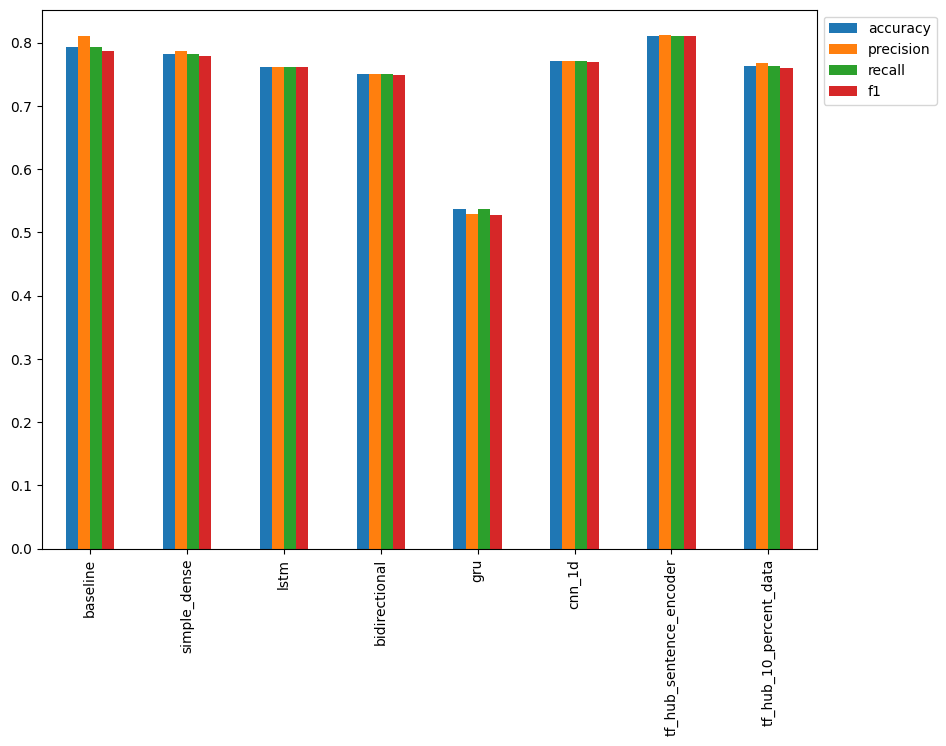

In [63]:
all_model_result["accuracy"] = all_model_result["accuracy"]/ 100

### Plotting and compare all of the model result in bar chart
all_model_result.plot(kind = "bar", figsize = (10, 7)).legend(bbox_to_anchor = (1.0, 1.0));

F1 score is harmonic mean of precision and recall, good for overall evaluation. Based on below data, we can conclude that USE tensorflow hub model performing better than all of the other models.

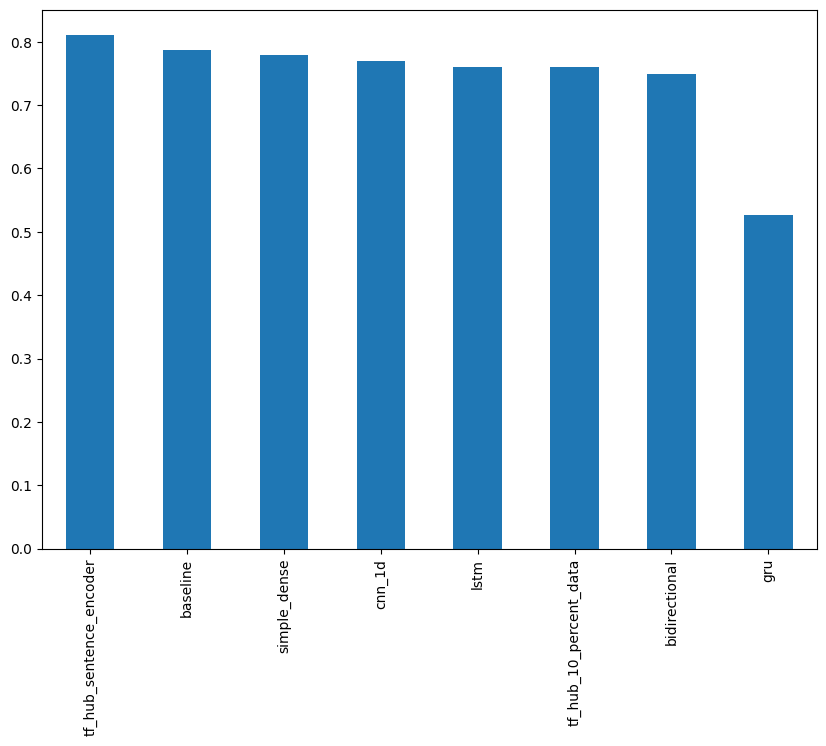

In [64]:
all_model_result.sort_values("f1", ascending = False)["f1"].plot(kind = "bar", figsize = (10, 7));

### 6. Model ensembling/ stacking

In [65]:
### Find maxima along the second axis for base model
baseline_pred_prob = np.max(first_model.predict_proba(val_sentence), axis = 1)

### Combine all probability of selected models
### Squeeze probability of LSTM and pretrained for combination
combined_pred_prob = baseline_pred_prob + tf.squeeze(second_model_pred_prob, axis = 1) + tf.squeeze(seventh_model_pred_prob)

### Average by 3 and round the value
combined_pred = tf.round(combined_pred_prob/ 3)
combined_pred[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [88]:
ensemble_result = performance_metrics(val_label, combined_pred)

all_model_result.loc["ensemble_result"] = ensemble_result
all_model_result.loc["ensemble_result"]["accuracy"] = all_model_result.loc["ensemble_result"]["accuracy"] / 100
all_model_result

C:\Users\Chris\AppData\Local\Temp\ipykernel_13264\2731320550.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_model_result.loc["ensemble_result"]["accuracy"] = all_model_result.loc["ensemble_result"]["accuracy"] / 100


,accuracy,precision,recall,f1
baseline,0.792651,0.811139,0.792651,0.786219
simple_dense,0.782152,0.786433,0.782152,0.779236
lstm,0.761155,0.760832,0.761155,0.760909
bidirectional,0.750656,0.750860,0.750656,0.749051
gru,0.536745,0.529368,0.536745,0.527263
cnn_1d,0.770341,0.770656,0.770341,0.769027
tf_hub_sentence_encoder,0.811024,0.811513,0.811024,0.810154
tf_hub_10_percent_data,0.763780,0.768467,0.763780,0.760126
ensemble_result,80.183727,0.802413,0.801837,0.802013
